In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import r_regression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embeddings = torch.load("/content/drive/MyDrive/GI_Project/AEEmbeddingsByFdcIDV5.pt")


In [ ]:
foodData = pd.read_csv(f"/content/drive/MyDrive/GI_Project/USDA_Nutrition_DataV2.csv")
# Drop all columns with 50% or more NaN values
foodData = foodData.dropna(thresh=foodData.shape[0]*0.2, axis=1)
# Drop all rows without at least 90% non NaN data
foodData = foodData.dropna(thresh=foodData.shape[1]*0.8, axis=0)
foodData.shape

(313674, 19)

In [ ]:
foodDataGi = pd.read_csv(f"/content/drive/MyDrive/GI_Project/NutritionDataUsdaGiMatched.csv")
gi_data = pd.read_csv("/content/drive/MyDrive/GI_Project/gi_data.csv", delimiter="\t")
foodDataGi['GI'] = gi_data['GI']
foodDataGi

,gi_name,usda_name,score,fdc_id,Protein [G],Total lipid (fat) [G],"Carbohydrate, by difference [G]",Ash [G],Energy [KCAL],Starch [G],...,SFA 12:0 [G],PUFA 18:2 [G],"Fatty acids, total monounsaturated [G]","Fatty acids, total polyunsaturated [G]","PUFA 18:2 n-6 c,c [G]",Epigallocatechin-3-gallate [MG],Inulin [G],"PUFA 18:3 n-3 c,c,c (ALA) [G]","Sugars, total including NLEA [G]",GI
0,"Cake, NS, decreased GI variant, sugar-to-flour...",Morrison's Hi Ratio Cake Flour,27.767183,2492814,6.67,0.00,80.00,NaN,367.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,20
1,"Carrot cake, prepared with wheat flour and coc...","COCONUT CARROT CAKE VEGAN MUFFIN, COCONUT CARR...",30.056784,2077739,3.64,16.36,56.36,NaN,382.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.73,37
2,Chocolate cake made from packet mix with choco...,CHOCOLATE CAKE MIX,30.066408,1860807,6.98,2.33,81.40,NaN,356.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.21,38
3,Chocolate mudcake,CHOCOLATE CHEESECAKE,33.959480,1665581,5.05,24.24,34.34,NaN,374.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.23,43
4,Christmas fruit cake,CHRISTMAS CAKE,35.892059,2484307,0.33,0.11,3.86,NaN,29.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.10,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,"Wholemeal bread (85 g), consumed with boiled e...",BREAD & 70% DARK CHOCOLATE,24.796761,2136799,7.55,35.85,49.06,NaN,472.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.30,55
4228,ZANHUO/ManaGI Egg Yolk Pastry,"APOLLO, FILLO PHYLLO PASTRY SHEETS",27.676426,1477116,8.33,3.12,54.17,NaN,271.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.08,28
4229,ZANHUO/ManaGI Matcha Crispbread,"CRISPBREAD, SESAME",30.705032,2024296,14.81,11.11,66.67,NaN,370.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,53
4230,ZANHUO/ManaGI Oat Bread (Americano Flavor),COUNTRY OAT BREAD MIX,30.381863,2011686,6.98,2.33,79.07,NaN,372.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.98,42


In [ ]:
# idsWithEmbedAndRating = foodRatings[foodRatings['fdc_id'].isin(embeddings.keys())]['fdc_id']

# embeddingDf = pd.DataFrame.from_dict({k: embeddings[k] for k in idsWithEmbedAndRating}, orient='index')
# embeddingDf = embeddingDf.merge(foodRatings, left_index=True, right_on='fdc_id')
# embeddingDf['rating'] = embeddingDf['rating'].apply(lambda x: 0 if x == 'junk' else 1)
# embeddingDf

In [ ]:
idsWithEmbedAndGi = foodDataGi[foodDataGi['fdc_id'].isin(embeddings.keys())]['fdc_id']

embeddingDf = pd.DataFrame.from_dict({k: embeddings[k] for k in idsWithEmbedAndGi}, orient='index')
embeddingDf = embeddingDf.merge(foodDataGi, left_index=True, right_on='fdc_id')
embeddingDf

,0,1,2,3,4,5,6,7,gi_name,usda_name,...,SFA 12:0 [G],PUFA 18:2 [G],"Fatty acids, total monounsaturated [G]","Fatty acids, total polyunsaturated [G]","PUFA 18:2 n-6 c,c [G]",Epigallocatechin-3-gallate [MG],Inulin [G],"PUFA 18:3 n-3 c,c,c (ALA) [G]","Sugars, total including NLEA [G]",GI
0,2.611673,1.790688,0.240555,1.297896,0.124967,0.0,1.797107,0.0,"Cake, NS, decreased GI variant, sugar-to-flour...",Morrison's Hi Ratio Cake Flour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,20
2095,2.611673,1.790688,0.240555,1.297896,0.124967,0.0,1.797107,0.0,"Cake, NS, sugar-to-flour ratio: 2.25 (Bakery S...",Morrison's Hi Ratio Cake Flour,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,51
1,2.211049,1.366467,0.562523,0.841992,1.486318,0.0,1.499829,0.0,"Carrot cake, prepared with wheat flour and coc...","COCONUT CARROT CAKE VEGAN MUFFIN, COCONUT CARR...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.73,37
2,2.222159,1.364657,0.699528,1.004792,1.837542,0.0,1.379605,0.0,Chocolate cake made from packet mix with choco...,CHOCOLATE CAKE MIX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.21,38
3,1.741191,1.092358,0.689959,0.484354,1.178529,0.0,1.827797,0.0,Chocolate mudcake,CHOCOLATE CHEESECAKE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.23,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,2.235621,1.495673,0.291737,0.761903,0.986158,0.0,1.684140,0.0,"Wholemeal bread (85 g), consumed with boiled e...",BREAD & 70% DARK CHOCOLATE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.30,55
4228,1.925061,1.589984,0.466444,1.117926,2.439596,0.0,1.484611,0.0,ZANHUO/ManaGI Egg Yolk Pastry,"APOLLO, FILLO PHYLLO PASTRY SHEETS",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.08,28
4229,1.780526,1.249575,1.070579,1.220410,1.634529,0.0,1.769355,0.0,ZANHUO/ManaGI Matcha Crispbread,"CRISPBREAD, SESAME",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,53
4230,2.166523,1.521210,0.491061,1.043000,1.915303,0.0,1.443563,0.0,ZANHUO/ManaGI Oat Bread (Americano Flavor),COUNTRY OAT BREAD MIX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.98,42


In [ ]:
embeddingDf = embeddingDf.dropna(thresh=embeddingDf.shape[0]*0.5, axis=1)
# Drop all rows without at least 90% non NaN data
embeddingDf = embeddingDf.dropna(thresh=embeddingDf.shape[1]*0.9, axis=0)
embeddingDf.shape

(3585, 28)

In [ ]:
embeddingDf.fillna(0, inplace=True)

In [ ]:
embeddingDf['GI_rel'] = embeddingDf['GI'].apply(lambda x: 0 if x > 50 else 1)

In [ ]:
from sklearn.feature_selection import r_regression

r_regression(embeddingDf.iloc[:,1:2], embeddingDf['GI'])

array([0.23955757])

In [ ]:
embeddingDf['Protein [G]']

0        6.67
2095     6.67
1        3.64
2        6.98
4        0.33
        ...  
4227     7.55
4228     8.33
4229    14.81
4230     6.98
4231     7.89
Name: Protein [G], Length: 3585, dtype: float64

In [ ]:
X = embeddingDf.iloc[:,0:8]
y = embeddingDf['GI']

In [ ]:
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

In [ ]:
for col in embeddingDf.columns[12:]:
    print(col)
    median = embeddingDf[col].median()
    plt.scatter(X_embedded[:,:1], X_embedded[:,1:2], c=embeddingDf[col].apply(lambda x: 0 if x < median else 1))
    plt.title("Latent space with " + col)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = MLPRegressor(hidden_layer_sizes=(32,64,32), random_state=1, max_iter=1000).fit(X_train, y_train)
regr.predict(X_test[:2])
regr.score(X_test, y_test)

0.10475820290401949

0.10475820290401949
[0.32872018]
18.259282743010072


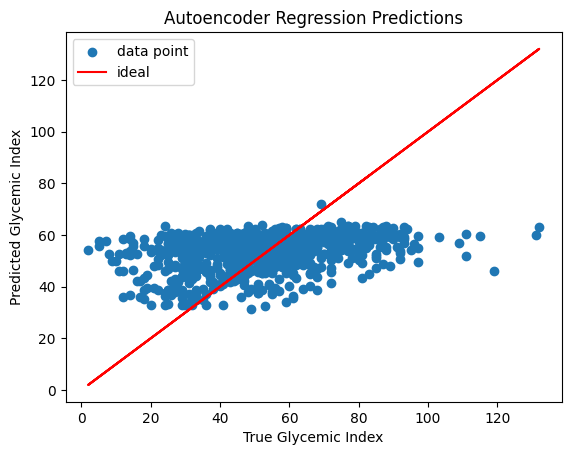

In [ ]:
y_pred = regr.predict(X_test)

print(r2_score(y_test, y_pred))
print(r_regression(y_test.to_numpy().reshape(-1,1), y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))
plt.scatter(y_test, y_pred)
plt.plot(y_test,y_test,'r')
plt.plot(y_test,y_test,'r')
plt.title("Autoencoder Regression Predictions")
plt.xlabel("True Glycemic Index")
plt.ylabel("Predicted Glycemic Index")
plt.legend(["data point", "ideal"])
plt.show()